In [ ]:
%pip install Pillow
%pip install pandas
%pip install matplotlib
%pip install scipy

In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import PIL
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

# Data Exploration

In [33]:
base_dir = 'data'
mask_dir = os.path.join(base_dir, 'with_mask')
wo_mask_dir = os.path.join(base_dir, 'without_mask')

In [34]:
mask_files = list(os.walk(mask_dir))[0][2]
print(f'number of mask pictures: {len(mask_files)}')
wo_mask_files = list(os.walk(wo_mask_dir))[0][2]
print(f'number of mask pictures: {len(wo_mask_files)}')

number of mask pictures: 3725
number of mask pictures: 3828


In [35]:
dimension_matrix = []
for i in range(len(mask_files)):
    image = PIL.Image.open(os.path.join(mask_dir,mask_files[i]))
    width, height = image.size
    dimension_matrix.append([width, height])
df = pd.DataFrame(dimension_matrix, columns=['width', 'height'])

(array([[<AxesSubplot:title={'center':'width'}>]], dtype=object),
 array([[<AxesSubplot:title={'center':'height'}>]], dtype=object))

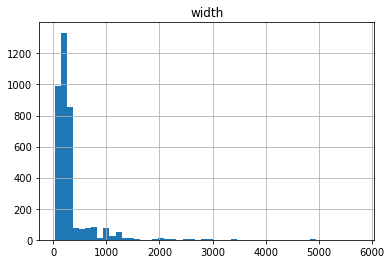

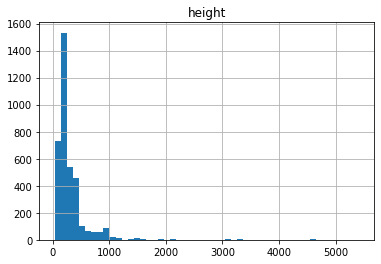

In [36]:
df.hist('width', bins=50), df.hist('height', bins=50)

In [37]:
dimension_matrix = []
for i in range(len(wo_mask_files)):
    image = Image.open(os.path.join(wo_mask_dir,wo_mask_files[i]))
    width, height = image.size
    dimension_matrix.append([width, height])
df = pd.DataFrame(dimension_matrix, columns=['width', 'height'])

(array([[<AxesSubplot:title={'center':'width'}>]], dtype=object),
 array([[<AxesSubplot:title={'center':'height'}>]], dtype=object))

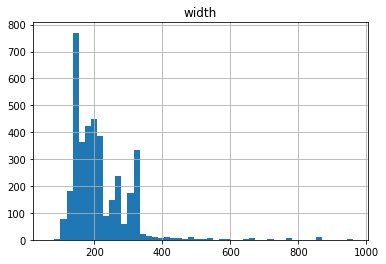

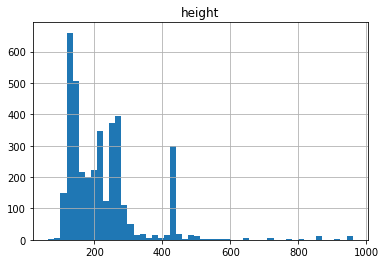

In [38]:
df.hist('width', bins=50), df.hist('height', bins=50)

In [39]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

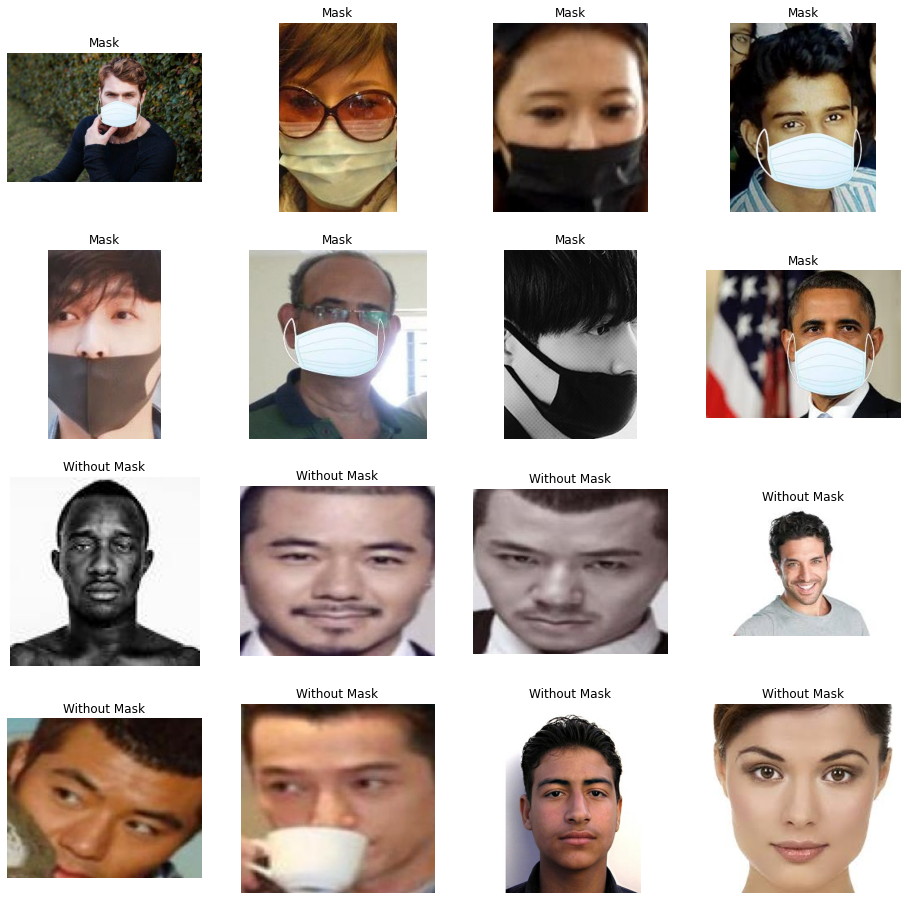

In [40]:

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_mask_pix = [os.path.join(mask_dir, fname) 
                for fname in mask_files[pic_index-8:pic_index]]
next_wo_mask_pix = [os.path.join(wo_mask_dir, fname) 
                for fname in wo_mask_files[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mask_pix+next_wo_mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = Image.open(img_path)
  plt.imshow(img)
  if i < 8:
    plt.title("Mask")
  else:
    plt.title("Without Mask")
plt.show()

In [41]:
base_model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(240, 240, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('with mask') and 1 for the other ('without mask')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
print("Num layers in base model: ", len(base_model.layers))

Num layers in base model:  13


In [43]:
from tensorflow.keras.optimizers import RMSprop

base_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(240, 240),  # All images will be resized to 240x240
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training') #set as training data

validation_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(240, 240),  # All images will be resized to 240x240
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation') #set as validation data

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [46]:
history = base_model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=5,
      verbose=1)

Epoch 1/5
14/47 [=======>......................] - ETA: 1:58 - loss: 0.8141 - accuracy: 0.5910

C:\Users\alexy\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 [==============================] - 191s 4s/step - loss: 0.5787 - accuracy: 0.7464 - val_loss: 0.3824 - val_accuracy: 0.8303
Epoch 2/5
47/47 [==============================] - 200s 4s/step - loss: 0.3103 - accuracy: 0.8656 - val_loss: 0.1963 - val_accuracy: 0.9318
Epoch 3/5
47/47 [==============================] - 184s 4s/step - loss: 0.2469 - accuracy: 0.9123 - val_loss: 0.2035 - val_accuracy: 0.9354
Epoch 4/5
47/47 [==============================] - 189s 4s/step - loss: 0.1801 - accuracy: 0.9336 - val_loss: 0.1464 - val_accuracy: 0.9545
Epoch 5/5
47/47 [==============================] - 183s 4s/step - loss: 0.1685 - accuracy: 0.9412 - val_loss: 0.1599 - val_accuracy: 0.9425


In [45]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)      

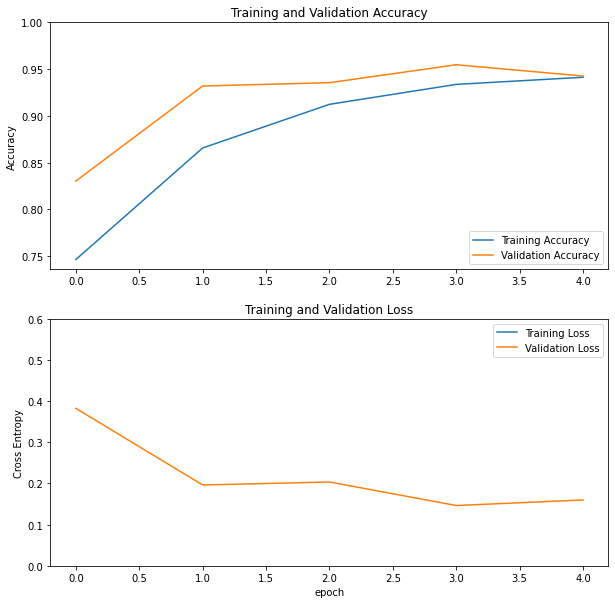

In [47]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
%pip install opencv-python

In [48]:
from cv2 import imread

In [49]:
def plot_image(image):
  image = image -tf.math.reduce_min(image)
  image = image / tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Data shape:  (350, 525, 3)


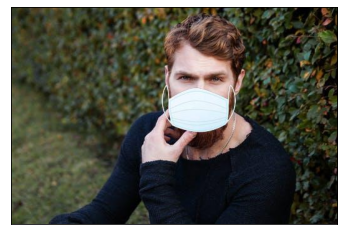

In [50]:
# first let's take a look at the image as a vector of pixels
masked = imread(os.path.join(mask_dir,mask_files[0]))
print("Data shape: ", masked.shape)
masked_img = PIL.Image.open(os.path.join(mask_dir,mask_files[0]))
plot_image(masked_img)

rows = masked.shape[0]
col = masked.shape[1]

lines = ''

for r in range(rows):
    lines += ','.join([f'{i}' for i in masked[r]]) + "\n" # append to create the csv file format

with open('masked.csv','w') as file:
    file.write(lines)

Data shape:  (100, 100, 3)


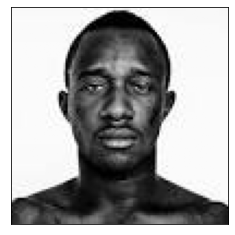

In [89]:
# first let's take a look at the image as a vector of pixels
unmasked = imread(os.path.join(wo_mask_dir,wo_mask_files[0]))
print("Data shape: ", unmasked.shape)
unmasked_img = PIL.Image.open(os.path.join(wo_mask_dir,wo_mask_files[0]))
plot_image(unmasked_img)

rows = unmasked.shape[0]
col = unmasked.shape[1]

lines = ''

for r in range(rows):
    lines += ','.join([f'{i}' for i in unmasked[r]]) + "\n" # append to create the csv file format

with open('unmasked.csv','w') as file:
    file.write(lines)

In [51]:
print([layer.name for layer in base_model.layers if 'conv' in layer.name])

['conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9']


In [53]:
import random

def get_submodel(layer_name):
  return tf.keras.models.Model(
      base_model.input,
      base_model.get_layer(layer_name).output
  )

get_submodel('conv2d_5').summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer)  [(None, 240, 240, 3)]    0         
                                                                 
 conv2d_5 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [58]:
def visualise_filter(layer_name, f_index = None, iters = 50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters -1)
  assert num_filters > f_index,'f_index is out of bounds'

  raw_image = imread(os.path.join(mask_dir,mask_files[0]))
  import cv2
  raw_image = cv2.resize(raw_image, (240,240))

  image = tf.convert_to_tensor(raw_image, dtype = tf.float32)
  verbose_step = int(iters/10)

  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      out = submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
      loss = tf.math.reduce_mean(out)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image+= grads *10

    if (i+1)%verbose_step == 0:
      print(f'Iteration: {i+1}, Loss: {loss.numpy():4f}')

  plot_image(image)

In [56]:
get_submodel('conv2d_9').summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer)  [(None, 240, 240, 3)]    0         
                                                                 
 conv2d_5 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        1849

Iteration: 5, Loss: 0.518223
Iteration: 10, Loss: 0.699916
Iteration: 15, Loss: 0.861192
Iteration: 20, Loss: 1.025831
Iteration: 25, Loss: 1.180982
Iteration: 30, Loss: 1.330709
Iteration: 35, Loss: 1.475590
Iteration: 40, Loss: 1.609740
Iteration: 45, Loss: 1.737930
Iteration: 50, Loss: 1.861062


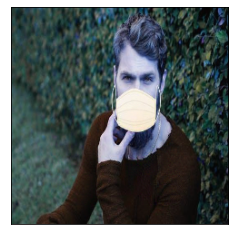

In [59]:
layer_name = 'conv2d_9' #@param ['conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9']
visualise_filter(layer_name)

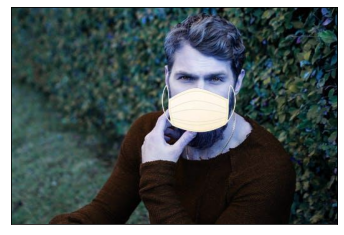

In [64]:
plot_image(imread(os.path.join(mask_dir,mask_files[0])))

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, 
                                        rotation_range=30,
                                    width_shift_range=0.02,
                                    height_shift_range=0.02,
                                    zoom_range=[0.8,1.2],
                                    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        base_dir,   
        target_size=(128, 128), 
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        color_mode='grayscale') 

validation_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(128, 128),  
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        color_mode='grayscale')

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [74]:
model = tf.keras.models.Sequential([ # trying a more cost-friendly cnn 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1), padding = 'same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 64)      

In [68]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 64)      

In [75]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=5,
      verbose=1)

Epoch 1/5
37/47 [======================>.......] - ETA: 11s - loss: 0.6674 - accuracy: 0.6000

C:\Users\alexy\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 [==============================] - 59s 1s/step - loss: 0.6604 - accuracy: 0.6169 - val_loss: 0.6296 - val_accuracy: 0.6534
Epoch 2/5
47/47 [==============================] - 73s 2s/step - loss: 0.5301 - accuracy: 0.7417 - val_loss: 0.5912 - val_accuracy: 0.6768
Epoch 3/5
47/47 [==============================] - 74s 2s/step - loss: 0.4807 - accuracy: 0.7735 - val_loss: 0.4478 - val_accuracy: 0.7869
Epoch 4/5
47/47 [==============================] - 70s 1s/step - loss: 0.4196 - accuracy: 0.8064 - val_loss: 0.5141 - val_accuracy: 0.7244
Epoch 5/5
47/47 [==============================] - 70s 1s/step - loss: 0.3635 - accuracy: 0.8340 - val_loss: 0.3602 - val_accuracy: 0.8366


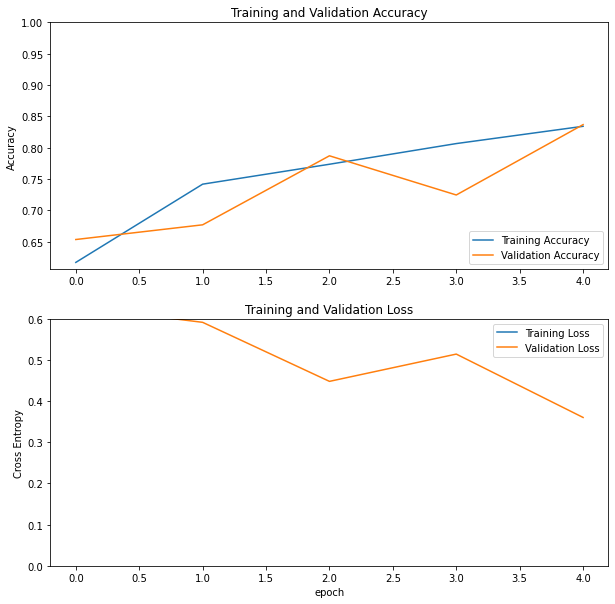

In [76]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(240, 240),  # All images will be resized to 240x240
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training') #set as training data

validation_generator = train_datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(240, 240),  # All images will be resized to 240x240
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation') #set as validation data

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [87]:
model_strides = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(240, 240, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu'), # adjusting step size
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop
model_strides.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model_strides.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 119, 119, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 59, 59, 32)        4640      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 13, 13, 64)     

In [88]:
history = model_strides.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=5,
      verbose=1)

Epoch 1/5
18/47 [==========>...................] - ETA: 59s - loss: 0.7336 - accuracy: 0.5647 

C:\Users\alexy\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


47/47 [==============================] - 113s 2s/step - loss: 0.6071 - accuracy: 0.6943 - val_loss: 0.3128 - val_accuracy: 0.9048
Epoch 2/5
47/47 [==============================] - 125s 3s/step - loss: 0.3098 - accuracy: 0.8722 - val_loss: 0.2223 - val_accuracy: 0.9268
Epoch 3/5
47/47 [==============================] - 125s 3s/step - loss: 0.2557 - accuracy: 0.9006 - val_loss: 0.5030 - val_accuracy: 0.8466
Epoch 4/5
47/47 [==============================] - 123s 3s/step - loss: 0.2248 - accuracy: 0.9177 - val_loss: 0.1827 - val_accuracy: 0.9368
Epoch 5/5
47/47 [==============================] - 112s 2s/step - loss: 0.1922 - accuracy: 0.9298 - val_loss: 0.1679 - val_accuracy: 0.9432


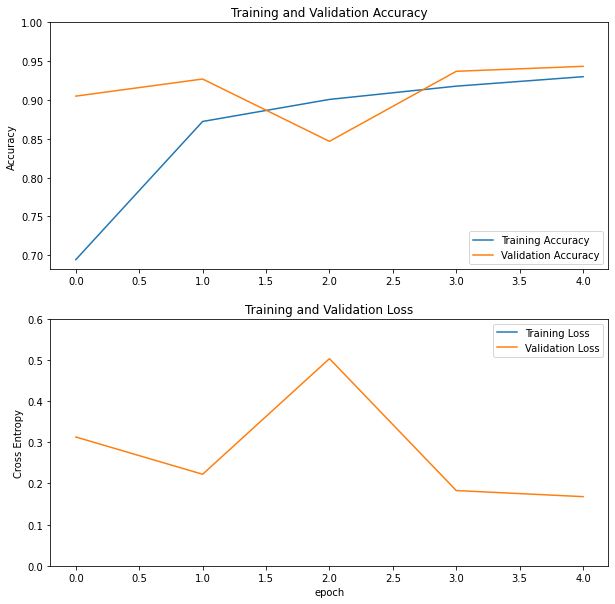

In [90]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [93]:
history = model_strides.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=5,
      verbose=1)

Epoch 1/5
47/47 [==============================] - 137s 3s/step - loss: 0.1720 - accuracy: 0.9385 - val_loss: 0.2209 - val_accuracy: 0.9134
Epoch 2/5
47/47 [==============================] - 142s 3s/step - loss: 0.1471 - accuracy: 0.9454 - val_loss: 0.1531 - val_accuracy: 0.9510
Epoch 3/5
47/47 [==============================] - 120s 3s/step - loss: 0.1237 - accuracy: 0.9574 - val_loss: 0.1321 - val_accuracy: 0.9553
Epoch 4/5
47/47 [==============================] - 124s 3s/step - loss: 0.1204 - accuracy: 0.9603 - val_loss: 0.1265 - val_accuracy: 0.9524
Epoch 5/5
47/47 [==============================] - 115s 2s/step - loss: 0.1078 - accuracy: 0.9611 - val_loss: 0.2118 - val_accuracy: 0.9162


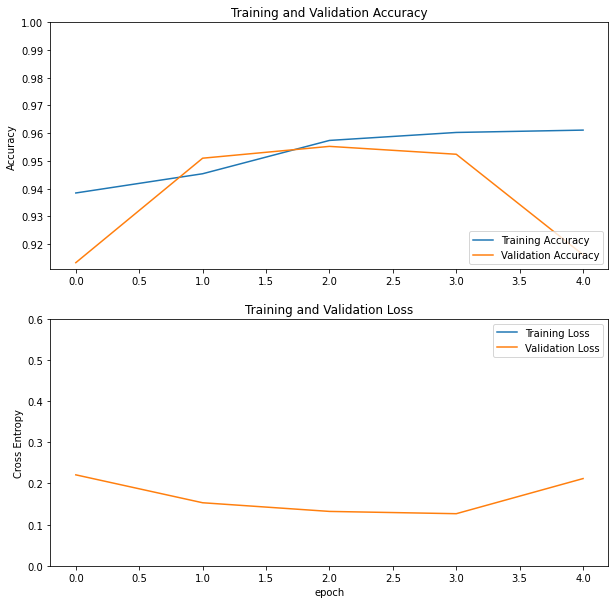

In [94]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [92]:
model_kernel = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (1,3), activation='relu', input_shape=(240, 240, 3)), # adjusting kernel size / filter size
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,1), strides=(2, 2), activation='relu'), # adjusting kernel size / filter size + strides (step size)
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop
model_kernel.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model_kernel.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 240, 238, 16)      160       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 120, 119, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 59, 60, 32)        1568      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 29, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 27, 28, 64)        18496     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 13, 14, 64)     

In [95]:
history = model_kernel.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,  
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs=5,
      verbose=1)

Epoch 1/5
47/47 [==============================] - 88s 2s/step - loss: 0.7054 - accuracy: 0.6489 - val_loss: 0.5251 - val_accuracy: 0.7266
Epoch 2/5
47/47 [==============================] - 87s 2s/step - loss: 0.3580 - accuracy: 0.8458 - val_loss: 0.2480 - val_accuracy: 0.9318
Epoch 3/5
47/47 [==============================] - 88s 2s/step - loss: 0.2519 - accuracy: 0.9050 - val_loss: 0.2028 - val_accuracy: 0.9375
Epoch 4/5
47/47 [==============================] - 89s 2s/step - loss: 0.2210 - accuracy: 0.9182 - val_loss: 0.2262 - val_accuracy: 0.9254
Epoch 5/5
47/47 [==============================] - 129s 3s/step - loss: 0.1933 - accuracy: 0.9285 - val_loss: 0.1746 - val_accuracy: 0.9496


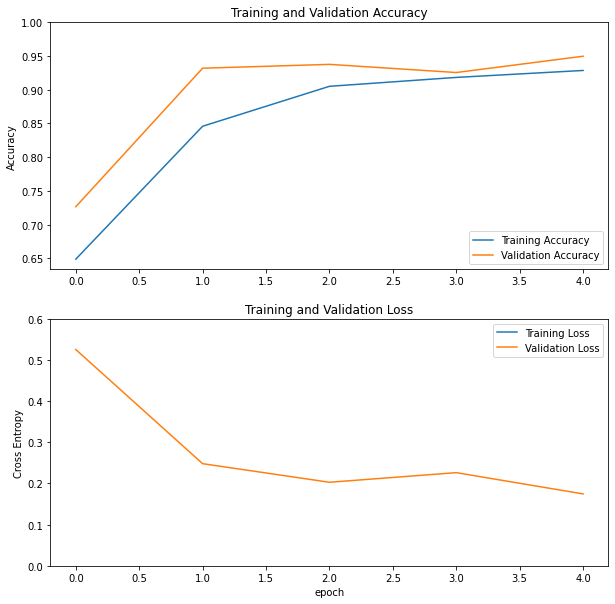

In [96]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()